In [1]:
import os,sys
import math

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from functools import reduce

import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold,cross_val_predict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sys.path.append("../../src")  # adjust path as needed
from read_Parkinsonpredict import ReadData, LoadData
from ml_models import MlModels

### Load the Data

In [2]:
# --- Load data
mri_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/PDMRI_Clean_Merged_6_13_25.csv")
gene_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/gene_expression_summary.csv")
nhy_latest = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/clean_mds_updrs.csv")

clinical_data = gene_data[["PATNO", "EVENT_ID", "GENDER", "AGE", "EDUC_YRS"]]
gene_data_expressions = gene_data.drop(columns=["GENDER", "AGE", "EDUC_YRS"])

print(clinical_data.columns)

Index(['PATNO', 'EVENT_ID', 'GENDER', 'AGE', 'EDUC_YRS'], dtype='object')


##### Baseline for Clinical Data

In [3]:
clinical_data_bl = clinical_data[clinical_data["EVENT_ID"] == "BL"]
clinical_data_clean = clinical_data_bl[clinical_data_bl['AGE'].notna()]
data_clean = clinical_data_clean.merge(nhy_latest, how='inner', on=["PATNO"])
X_data = data_clean.drop(columns=['PATNO', 'EVENT_ID_x', 'EVENT_ID_y', 'NHY'])
X_data['GENDER'] = X_data['GENDER'].map({"Female": 1, "Male": 0})

Y_data = data_clean["NHY"].copy()
Y_data[Y_data == 0] = 0
Y_data[(Y_data == 1) | (Y_data == 2)] = 1
Y_data[Y_data > 2] = 2

print(Y_data.shape, X_data.shape)

(930,) (930, 3)


##### Visualize the grouped data

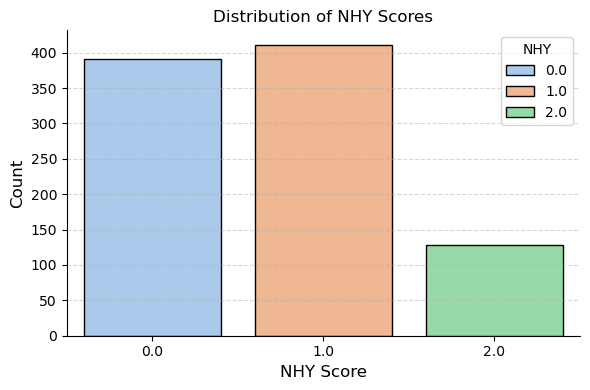

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x='NHY', data=Y_data.to_frame(name="NHY"), hue='NHY', palette='pastel', edgecolor='black')
plt.title("Distribution of NHY Scores", fontsize=12)
plt.xlabel("NHY Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

### Logistic Regression model

Splitting the trainning data further into train and validation set for regular logistic regression

In [6]:
X_, X_test, Y_, Y_test = train_test_split(X_data, Y_data, test_size=0.2, shuffle=True, random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_, Y_, test_size=0.15, shuffle=True, random_state=42)

data = {}
data['X_train'] = X_train
data['Y_train'] = Y_train

#### Logistic Regression

In [7]:
clinical_model_l = MlModels(model_name = 'logistic', data=data, params = None, pca_flag=False)
clinicalmodel_logistic = clinical_model_l.build_model()

params_cv = {'cv':StratifiedKFold(n_splits=5)}
clinical_model_cv = MlModels(model_name = 'logistic_cv', data=data, params = params_cv, pca_flag=False)
clinicalmodel_logistic_cv = clinical_model_cv.build_model()

predictions1 = clinical_model_l.predict(X_cv)
predictions2 = clinical_model_cv.predict(X_cv)

print("Validation Accuracy (logistic_regular):", accuracy_score(Y_cv.values.ravel(), predictions1))
print("Classification Report(logistic_regular):\n", classification_report(Y_cv.values.ravel(), predictions1, zero_division=0))
# print("Confusion Matrix (logistic_regular):\n", confusion_matrix(Y_cv.values.ravel(), predictions1))

print("Validation Accuracy (logistic_Kfold):", accuracy_score(Y_cv.values.ravel(), predictions2))
print("Classification Report (logistic_Kfold):\n", classification_report(Y_cv.values.ravel(), predictions2, zero_division=0))


Validation Accuracy (logistic_regular): 0.5
Classification Report(logistic_regular):
               precision    recall  f1-score   support

         0.0       0.47      0.61      0.53        46
         1.0       0.53      0.57      0.55        49
         2.0       0.00      0.00      0.00        17

    accuracy                           0.50       112
   macro avg       0.33      0.39      0.36       112
weighted avg       0.43      0.50      0.46       112

Validation Accuracy (logistic_Kfold): 0.5089285714285714
Classification Report (logistic_Kfold):
               precision    recall  f1-score   support

         0.0       0.48      0.61      0.54        46
         1.0       0.54      0.59      0.56        49
         2.0       0.00      0.00      0.00        17

    accuracy                           0.51       112
   macro avg       0.34      0.40      0.37       112
weighted avg       0.43      0.51      0.47       112



/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


#### Balanced class weights

In [8]:
params_cv = {'cv':StratifiedKFold(n_splits=5),'class_weight': 'balanced' }
clinical_cv_pca1 = MlModels(model_name = 'logistic_cv', data=data, params = params_cv, pca_flag=False)
mymodel_logistic_cv_pca1 = clinical_cv_pca1.build_model()
predictions5 = clinical_cv_pca1.predict(X_cv)
print("Validation Accuracy (logistic_Kfold):", accuracy_score(Y_cv.values.ravel(), predictions5))
print("Classification Report (logistic_Kfold):\n", classification_report(Y_cv.values.ravel(), predictions5, zero_division=0))

Validation Accuracy (logistic_Kfold): 0.44642857142857145
Classification Report (logistic_Kfold):
               precision    recall  f1-score   support

         0.0       0.44      0.17      0.25        46
         1.0       0.58      0.63      0.61        49
         2.0       0.27      0.65      0.38        17

    accuracy                           0.45       112
   macro avg       0.43      0.48      0.41       112
weighted avg       0.48      0.45      0.43       112



/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


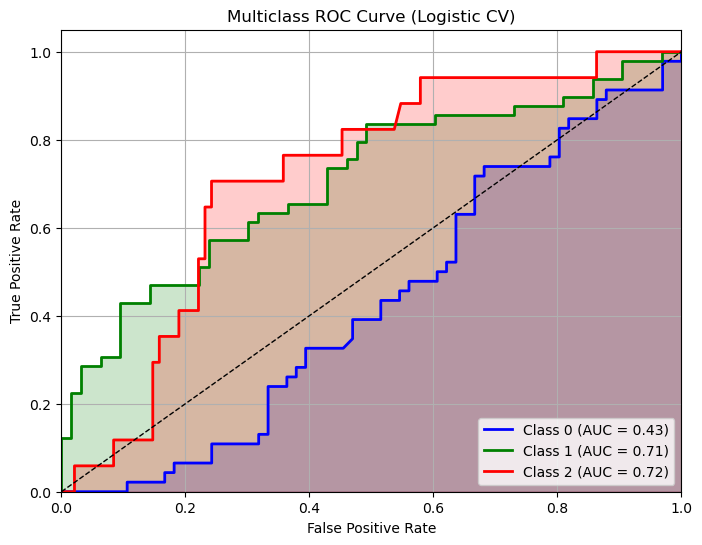

In [9]:
y_score = clinical_cv_pca1.model.predict_proba(X_cv)
from sklearn.preprocessing import label_binarize

# Make sure your Y_cv is binarized (one-hot encoded)
y_true = label_binarize(Y_cv.values.ravel(), classes=[0, 1, 2])
n_classes = y_true.shape[1]
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    
    # Fill under the curve
    plt.fill_between(fpr[i], 0, tpr[i], color=colors[i], alpha=0.2)

# Diagonal line = random
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (Logistic CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### MRI Data and Clinical Data

In [5]:
clinical_bl_clean = data_clean
mri_data_clean = mri_data.merge(clinical_bl_clean, how='inner', on=["PATNO"])
mri_drop_f = ["lh_MeanThickness", "lh_WhiteSurfArea", "rhCerebralWhiteMatterVol", "lhCerebralWhiteMatterVol"]
mri_drop_list = mri_drop_f + ["EVENT_ID_x", "EVENT_ID_y", "EVENT_ID", 'PATNO', "NHY"]
X_data_mri = mri_data_clean.drop(columns=["EVENT_ID_x", "EVENT_ID_y", "EVENT_ID", 'PATNO', "NHY"])

X_data_mri['GENDER'] = X_data_mri['GENDER'].map({"Female": 1, "Male": 0})
Y_data_mri = mri_data_clean["NHY"].copy()
Y_data_mri[Y_data_mri == 0] = 0
Y_data_mri[(Y_data_mri == 1) | (Y_data_mri == 2)] = 1
Y_data_mri[Y_data_mri > 2] = 2


In [6]:
Xmri_, X_test_mri, Ymri_, Y_test_mri = train_test_split(X_data_mri, Y_data_mri, test_size=0.2, shuffle=True, random_state=42)
X_train_mri, X_cv_mri, Y_train_mri, Y_cv_mri = train_test_split(Xmri_, Ymri_, test_size=0.15, shuffle=True, random_state=42)

data_mri = {}
data_mri['X_train'] = X_train_mri
data_mri['Y_train'] = Y_train_mri


In [12]:
mri_model_l = MlModels(model_name = 'logistic', data=data_mri, params = None, pca_flag=False)
mrimodel_logistic = mri_model_l.build_model()

params_cv = {'cv':StratifiedKFold(n_splits=5)}
mri_model_cv = MlModels(model_name = 'logistic_cv', data=data_mri, params = params_cv, pca_flag=False)
mrimodel_logistic_cv = mri_model_cv.build_model()

predictions1 = mri_model_l.predict(X_cv_mri)
predictions2 = mri_model_cv.predict(X_cv_mri)

print("Validation Accuracy (logistic_regular):", accuracy_score(Y_cv_mri.values.ravel(), predictions1))
print("Classification Report(logistic_regular):\n", classification_report(Y_cv_mri.values.ravel(), predictions1, zero_division=0))
# print("Confusion Matrix (logistic_regular):\n", confusion_matrix(Y_cv.values.ravel(), predictions1))

print("Validation Accuracy (logistic_Kfold):", accuracy_score(Y_cv_mri.values.ravel(), predictions2))
print("Classification Report (logistic_Kfold):\n", classification_report(Y_cv_mri.values.ravel(), predictions2, zero_division=0))

/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (logistic_regular): 0.4805194805194805
Classification Report(logistic_regular):
               precision    recall  f1-score   support

         0.0       0.56      0.71      0.62        34
         1.0       0.48      0.38      0.43        34
         2.0       0.00      0.00      0.00         9

    accuracy                           0.48        77
   macro avg       0.35      0.36      0.35        77
weighted avg       0.46      0.48      0.46        77

Validation Accuracy (logistic_Kfold): 0.5064935064935064
Classification Report (logistic_Kfold):
               precision    recall  f1-score   support

         0.0       0.50      0.76      0.60        34
         1.0       0.52      0.38      0.44        34
         2.0       0.00      0.00      0.00         9

    accuracy                           0.51        77
   macro avg       0.34      0.38      0.35        77
weighted avg       0.45      0.51      0.46        77



##### Applying PCA

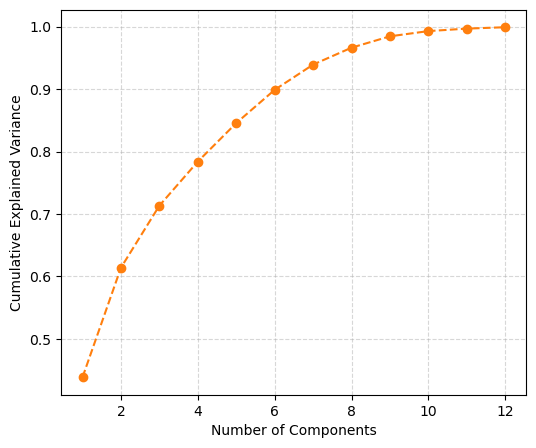

In [16]:
#Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_mri)

# Step 3: Apply PCA
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
fig = plt.figure(figsize=(6,5),dpi=100)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o--',color='tab:orange')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [20]:
params_cv = {'cv':StratifiedKFold(n_splits=5),'class_weight': 'balanced' }
mri_cv_pca4 = MlModels(model_name = 'logistic_cv', data=data_mri, params = params_cv, pca_flag=True, pca_components=7)
mri_model_logistic_cv_pca4 = mri_cv_pca4.build_model()
predictions5 = mri_cv_pca4.predict(X_cv_mri)
print("Validation Accuracy (logistic_Kfold):", accuracy_score(Y_cv_mri.values.ravel(), predictions5))
print("Classification Report (logistic_Kfold):\n", classification_report(Y_cv_mri.values.ravel(), predictions5, zero_division=0))

Validation Accuracy (logistic_Kfold): 0.33766233766233766
Classification Report (logistic_Kfold):
               precision    recall  f1-score   support

         0.0       0.80      0.12      0.21        34
         1.0       0.53      0.53      0.53        34
         2.0       0.11      0.44      0.17         9

    accuracy                           0.34        77
   macro avg       0.48      0.36      0.30        77
weighted avg       0.60      0.34      0.34        77



/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Balanced Class Weights

In [7]:
params_cv = {'cv':StratifiedKFold(n_splits=5),'class_weight': 'balanced' }
mri_cv_pca4 = MlModels(model_name = 'logistic_cv', data=data_mri, params = params_cv, pca_flag=False)
mri_model_logistic_cv_pca4 = mri_cv_pca4.build_model()
predictions5 = mri_cv_pca4.predict(X_cv_mri)
print("Validation Accuracy (logistic_Kfold):", accuracy_score(Y_cv_mri.values.ravel(), predictions5))
print("Classification Report (logistic_Kfold):\n", classification_report(Y_cv_mri.values.ravel(), predictions5, zero_division=0))

/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (logistic_Kfold): 0.3116883116883117
Classification Report (logistic_Kfold):
               precision    recall  f1-score   support

         0.0       0.80      0.12      0.21        34
         1.0       0.50      0.50      0.50        34
         2.0       0.08      0.33      0.13         9

    accuracy                           0.31        77
   macro avg       0.46      0.32      0.28        77
weighted avg       0.58      0.31      0.33        77



#### Conclusion from the baseline model : The MRI data has non-linear features and hence don't perfrom well enough with Logistic Regression

### Baseline All data

In [3]:
# --- Load data
mri_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/PDMRI_Clean_Merged_6_13_25.csv")
gene_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/gene_expression_summary.csv")
nhy_latest = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/clean_mds_updrs.csv")

mri_data_bl  = mri_data.query("EVENT_ID == 'BL'")
gene_data_bl  = gene_data.query("EVENT_ID == 'BL'")
gene_data_bl = gene_data_bl[gene_data_bl["AGE"].notna()].copy()

gene_data_bl = gene_data_bl.rename(columns={"NHY": "NHY_BL"})

baseline_dfs = [mri_data_bl,gene_data_bl]

baseline_merged = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=["PATNO", "EVENT_ID"],   
        how="inner",                
        suffixes=("", "_dup")       
    ),
    baseline_dfs
)

baseline_merged = baseline_merged.drop(columns=["EVENT_ID"])
baseline_merged = baseline_merged.loc[:,~baseline_merged.columns.str.endswith("_dup")]
baseline_merged = baseline_merged.sort_values("PATNO").reset_index(drop=True)
baseline_merged["PATNO"] = baseline_merged["PATNO"].astype("Int64")

baseline_merged = baseline_merged.merge(nhy_latest,
                      how = 'left',
                      on = "PATNO",
                      suffixes=("", "_dup"))

baseline_merged = baseline_merged[baseline_merged["NHY"].notna() & (baseline_merged["NHY"] != 101)]

mri_drop_f = ["lh_MeanThickness", "lh_WhiteSurfArea", "rhCerebralWhiteMatterVol", "lhCerebralWhiteMatterVol"]
mri_drop_list = mri_drop_f + ["EVENT_ID", "NHY_BL", "NHY", 'PATNO', 'MRIRSLT']
X_data = baseline_merged.drop(columns=mri_drop_list)

X_data['GENDER'] = X_data['GENDER'].map({"Female": 1, "Male": 0})
Y_data = baseline_merged["NHY"].copy()
Y_data[Y_data == 0] = 0
Y_data[(Y_data == 1) | (Y_data == 2)] = 1
Y_data[Y_data > 2] = 2

print(X_data.shape, Y_data.shape)

X_, X_test, Y_, Y_test = train_test_split(X_data, Y_data, test_size=0.2, stratify=Y_data, shuffle=True, random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_, Y_, test_size=0.15, stratify=Y_, shuffle=True, random_state=42)

data = {}
data['X_train'] = X_train
data['Y_train'] = Y_train

print(X_train.shape, X_cv.shape)

(639, 110) (639,)
(434, 110) (77, 110)


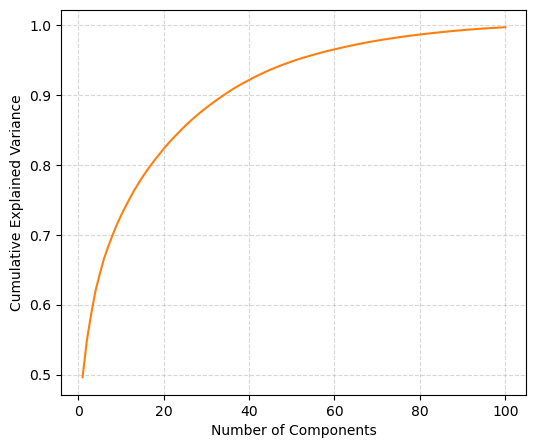

In [5]:
#Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Step 3: Apply PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
fig = plt.figure(figsize=(6,5),dpi=100)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, '-',color='tab:orange')
plt.grid(alpha=0.5, linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
params_cv = {
    'cv': StratifiedKFold(n_splits=5),
    'penalty': 'l2',
    'class_weight': 'balanced'
}

all_data_model = MlModels(model_name = 'logistic_cv', data=data, params = params_cv, pca_flag=False)
all_data_model_mymodel = all_data_model.build_model()
predictions6 = all_data_model_mymodel.predict(X_cv)
print("Validation Accuracy (logistic_Kfold):", accuracy_score(Y_cv.values.ravel(), predictions6))
print("Classification Report (logistic_Kfold):\n", classification_report(Y_cv.values.ravel(), predictions6, zero_division=0))

/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (logistic_Kfold): 0.44155844155844154
Classification Report (logistic_Kfold):
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        33
         1.0       0.44      1.00      0.61        34
         2.0       0.00      0.00      0.00        10

    accuracy                           0.44        77
   macro avg       0.15      0.33      0.20        77
weighted avg       0.19      0.44      0.27        77



/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


In [8]:
params_cv = {
    'cv': StratifiedKFold(n_splits=5),
    'penalty': 'l2',
    'class_weight': 'balanced'
}

all_data_model_pca = MlModels(model_name = 'logistic_cv', data=data, params = params_cv, pca_flag=True, pca_components=60)
all_data_model_mymodel_pca = all_data_model_pca.build_model()
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=60)
X_pca = pca.fit_transform(X_test_scaled)



predictions5 = all_data_model_mymodel_pca.predict(pca.transform(X_cv))

print("Validation Accuracy (logistic_Kfold):", accuracy_score(Y_cv.values.ravel(), predictions5))
print("Classification Report (logistic_Kfold):\n", classification_report(Y_cv.values.ravel(), predictions5, zero_division=0))

/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy (logistic_Kfold): 0.44155844155844154
Classification Report (logistic_Kfold):
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        33
         1.0       0.44      1.00      0.61        34
         2.0       0.00      0.00      0.00        10

    accuracy                           0.44        77
   macro avg       0.15      0.33      0.20        77
weighted avg       0.19      0.44      0.27        77



/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
